In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from exp.nb_03Magda import *
from exp.nb_04Magda_corrected import *

## Get data

In [3]:
train_x, train_y, valid_x, valid_y, test_x, test_y = get_mnist()

In [4]:
norm = lambda x: normalize(train_x, x)
train_x, valid_x, test_x = [norm(x) for x in (train_x, valid_x, test_x)]

In [5]:
mnist_bunch = DataBunch(train_x, train_y, valid_x, valid_y, 5000)

## Get learner and callbacks

In [6]:
#export
class Callback():
    "Base class for callbacks"
    def init_learner(self, learner):
        self.learner = learner
    
    def class_name(self):
        return self.__class__.__name__.lower()

class AccuracyCallback(Callback):
    "Callback calculating validation accuracy"
    def fit_begin(self, *args):
        self.learner.metrics['val_accuracies'] = []

    def validation_batch_end(self, logits, *args, **kwargs):
        preds = logits.argmax(1)
        targets = self.learner.batch_y
        self.num_correct = (preds==targets).float().sum()
        self.num_total = len(logits)
        accuracy = self.num_correct / self.num_total
        self.learner.metrics['val_accuracies'].append(accuracy.item())

    def fit_end(self, *args):
        accuracies = self.learner.metrics['val_accuracies']
        print(f'Final accuracy: {accuracies[-1]:4.6f}')

class LossCallback(Callback):
    "Callback calculating train and validation losses"
    def fit_begin(self, *args):
        self.learner.metrics['train_losses'] = []
        self.learner.metrics['valid_losses'] = []

    def train_batch_end(self, loss, *args, **kwargs):
        self.learner.metrics['train_losses'].append(loss.item())

    def validation_batch_end(self, logits, loss, *args, **kwargs):
        self.learner.metrics['valid_losses'].append(loss.item())

    def epoch_end(self, *args):
        print('train: ', self.learner.metrics['train_losses'][-1],
              'validation: ', self.learner.metrics['valid_losses'][-1])

import matplotlib.pyplot as plt
class PlotsCallback(Callback):
    "Callback adding plotting methods to learner"
    def fit_begin(self, *args):
        self.learner.plot_train_loss = self._plot_train_loss
        self.learner.plot_validation_loss = self._plot_validation_loss
        self.learner.plot_accuracy = self._plot_accuracy
        self.learner.plot_lr = self._plot_lr

    def _plot_train_loss(self):
        assert 'train_losses' in self.learner.metrics, 'Losses have not been recorded during training'
        fig, ax = plt.subplots()
        ax.plot(self.learner.metrics['train_losses'], label='train')
        ax.set_title('Train loss')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Cross_entropy')

    def _plot_validation_loss(self):
        assert 'valid_losses' in self.learner.metrics, 'Losses have not been recorded during training'
        fig, ax = plt.subplots()
        ax.plot(self.learner.metrics['valid_losses'], label='valid')
        ax.set_title('Validation loss')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Cross_entropy')

    def _plot_accuracy(self):
        assert 'val_accuracies' in self.learner.metrics, 'Accuracy has not been recorded during training'
        fig, ax = plt.subplots()
        ax.plot(self.learner.metrics['val_accuracies'])
        ax.set_title('Validation accuracy')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Accuracy (%)')        
    
    def _plot_lr(self):
        assert 'lr' in self.learner.metrics, 'Learning rate has not been recorded during training'
        fig, ax = plt.subplots()
        ax.plot(self.learner.metrics['lr'])
        ax.set_title('Learning rates')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('lr')     

class EarlyStopping(Exception):
    pass

class EarlyStoppingCallback(Callback):
    def epoch_end(self):
        last_accuracy = self.learner.metrics.get('val_accuracies',[0])[-1]
        print(self.learner.epoch, 'last accuracy: ', last_accuracy)
        if last_accuracy > 0.9:
            raise EarlyStopping(f'Accuracy above 90\%, stopping after epoch {self.learner.epoch}.')

In [7]:
#export
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from exp.nb_04Magda_corrected import *
class Learner():
    def __init__(self, data_bunch, callback_list=[]):
        assert isinstance(data_bunch, DataBunch), 'First paramtere should be a DataBunch'
        assert isinstance(callback_list, list), 'Second paramters should be a LIST (of callbacks)'
        self.data_bunch = data_bunch
        self.classes = len((self.data_bunch.train_data[:][1]).unique())
        self._get_model(num_out=self.classes)
        self._get_optimizer()
        self._loss_func()
        self.callback_list = callback_list + [PlotsCallback()]
        for cb in self.callback_list:
            cb.init_learner(self)
        self.epoch = 0
        self.batch_x = None
        self.batch_y = None
        self.metrics = {}


    def _get_model(self, num_hidden=50, num_out=10):
        num_in = self.data_bunch.train_data[:][0].size(1)
        self.model = nn.Sequential(nn.Linear(num_in, num_hidden), nn.ReLU(), nn.Linear(num_hidden, num_out))

    def _get_optimizer(self, lr=0.5):
        self.optimizer = optim.SGD(self.model.parameters(), lr=lr)

    def _loss_func(self):
        self.loss_func = F.cross_entropy

    def forward(self, bx, by):
        logits = self.model(bx)
        loss = self.loss_func(logits, by)
        return logits, loss

    def backward(self, loss):
        loss.backward()
        self.callback('before_optim_step')
        self.optimizer.step()
        self.optimizer.zero_grad()

    def fit(self, epochs):
        assert isinstance(epochs, int), 'Number of epochs should be INT'
        self.total_epochs = epochs
        self.callback('fit_begin')
        for self.epoch in range(epochs):
            try:
                self.model.train()
                self.callback('train_begin')
                for (self.batch_x, self.batch_y) in self.data_bunch.train_dl:
                    self.callback('train_batch_begin')
                    logits, loss = self.forward(self.batch_x, self.batch_y)
                    self.backward(loss)
                    self.callback('train_batch_end', loss)
                self.model.eval()
                with torch.no_grad():
                    self.callback('validation_begin')
                    for (self.batch_x, self.batch_y) in self.data_bunch.valid_dl:
                        self.callback('validation_batch_begin')
                        logits, loss = self.forward(self.batch_x, self.batch_y)
                        self.callback('validation_batch_end', logits, loss)
                self.callback('epoch_end')
            except EarlyStopping:
                print(self.epoch, 'stopping ... ')
                break
        self.callback('fit_end')

    def callback(self, cb_name, *args, **kwargs):
        for cb in self.callback_list:
            cb_method = getattr(cb, cb_name, None)
            if cb_method:
                cb_method(*args, **kwargs)

In [8]:
learner = Learner(mnist_bunch, [AccuracyCallback(), LossCallback()])

In [9]:
learner.fit(3)

train:  1.170127511024475 validation:  1.4694068431854248
train:  1.1595667600631714 validation:  1.0507398843765259
train:  0.5154829025268555 validation:  0.3812672197818756
Final accuracy: 0.893600


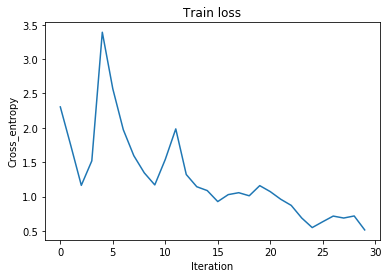

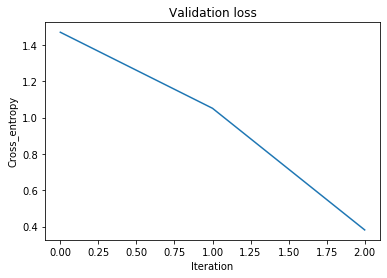

In [10]:
learner.plot_train_loss()
learner.plot_validation_loss()

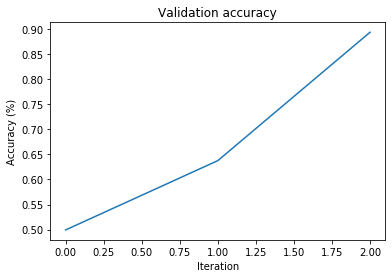

In [11]:
learner.plot_accuracy()

## Scheduler

In [12]:
#export
import math
class ParamScheduler(Callback):
    "Callback for parameter schedulling"
    def __init__(self, param_name, sched_func, *args):
        self.param_name = param_name
        self.sched_func = getattr(self, sched_func, None)
        self.args = args
        
    def fit_begin(self, *args):
        self.learner.metrics[self.param_name] = []
        self.iters = len(self.learner.data_bunch.train_dl)
        for pg in self.learner.optimizer.param_groups:
            pg[self.param_name] = self.args[0]
        
    def train_begin(self, *args):
        self.iter = 0.

    def train_batch_begin(self, *args):
        epoch_iter = self.learner.epoch + (self.iter / self.iters)
        for pg in self.learner.optimizer.param_groups:
            position =  epoch_iter / self.learner.total_epochs
            pg[self.param_name] = self.sched_func(position, *self.args)
        self.learner.metrics[self.param_name].append(pg[self.param_name])       
        self.iter += 1.
            
    def linear_sched(self, position, start, end, *args):
        return start + position * (end-start)
    
    def cosine_sched(self, position, start, end, *args):
        return start + (1 + math.cos(math.pi *(1 - position))) * (end-start)/2
    
    def fixed_sched(self, position, start, *args):
        return start

class CombineScheduler(Callback):
    "Callback for combined parameter schedulling"
    def __init__(self, param_name, prop_list, sched_list, start, mid, end):
        self.param_name = param_name
        assert sum(prop_list)==1, 'Proportions must equal to 1'
        assert len(prop_list)==len(sched_list)==2, 'Number of proportions and schedules must equal'
        self.prop_list = prop_list
        self.sched_list = sched_list
        self.start, self.mid, self.end = start, mid, end
    
    def fit_begin(self, *args):
        self.iters = len(self.learner.data_bunch.train_dl)
        self.split = self.prop_list[0] * self.learner.total_epochs
        self.learner.metrics[self.param_name] = []
        for pg in self.learner.optimizer.param_groups:
            pg[self.param_name] = self.start
        self.p1 = ParamScheduler(self.param_name, self.sched_list[0], self.start, self.mid)
        self.p2 = ParamScheduler(self.param_name, self.sched_list[1], self.mid, self.end)
        self.p1.init_learner(self.learner)
        self.p2.init_learner(self.learner)
        
    def train_begin(self, *args):
        self.iter = 0.

    def train_batch_begin(self, *args):
        epoch_iter = self.learner.epoch + (self.iter / self.iters)
        for pg in self.learner.optimizer.param_groups:
            if epoch_iter < self.split:
                position = epoch_iter / self.split
                pg[self.param_name] = self.p1.sched_func(position, self.start, self.mid)
            else:
                position = (epoch_iter-self.split) / (self.learner.total_epochs-self.split)
                pg[self.param_name] = self.p2.sched_func(position, self.mid, self.end)
        self.learner.metrics[self.param_name].append(pg[self.param_name])       
        self.iter += 1.            

In [13]:
learner = Learner(mnist_bunch, [AccuracyCallback(), ParamScheduler('lr', 'cosine_sched', 1, 0.1)])

In [14]:
learner.fit(3)

Final accuracy: 0.805000


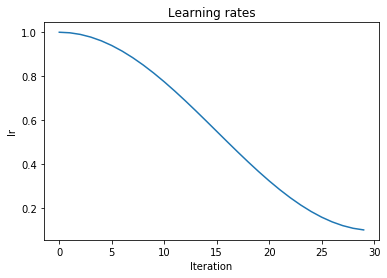

In [15]:
learner.plot_lr()

In [16]:
learner = Learner(mnist_bunch, [AccuracyCallback(), CombineScheduler('lr', [0.3, 0.7], ['cosine_sched', 'cosine_sched'], 0.1, 1, 0.1)])

In [17]:
learner.fit(3)

Final accuracy: 0.554300


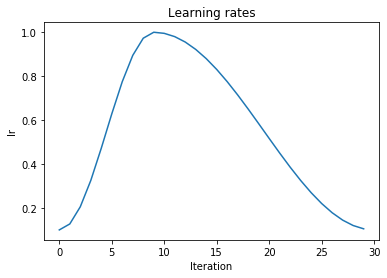

In [18]:
learner.plot_lr()

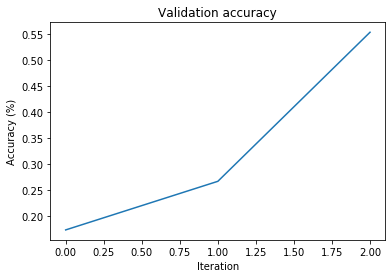

In [19]:
learner.plot_accuracy()

In [5]:
!./notebook2script.py 05bMagda_annealing.ipynb

Converted 05bMagda_annealing.ipynb to exp/nb_05bMagda.py
